In [160]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


In [161]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\CHINMAY\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [162]:
df = pd.read_csv(r"D:\Chinmay\ML PROJECTS\Fake News Detection\Shuffled_SAMPLE.csv")
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle dataset

In [163]:
# ----------- Cell 3: Text Preprocessing Function -----------
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', str(text))
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if word not in stop_words]
    return ' '.join(text)

In [164]:
# ----------- Cell 4: Apply Text Cleaning -----------
df['cleaned_text'] = df['Headline'].astype(str).apply(clean_text)
df = df[df['cleaned_text'].str.strip() != '']  # Remove empty cleaned_text

In [165]:
# ----------- Cell 5: Convert Labels to Numeric -----------
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])  # 'FAKE' -> 1, 'REAL' -> 0

In [166]:
# ----------- Cell 6: Split Dataset -----------
X = df['cleaned_text']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [167]:
# ----------- Cell 7: Build Pipeline -----------
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.7, min_df=5)),
    ('clf', LogisticRegression())
])

In [168]:

# ----------- Cell 8: Hyperparameter Tuning -----------
parameters = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['liblinear', 'saga'],
    'clf__max_iter': [500, 1000]
}


In [169]:
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.2f}")

Best Parameters: {'clf__C': 10, 'clf__max_iter': 500, 'clf__solver': 'liblinear', 'tfidf__ngram_range': (1, 1)}
Best Accuracy: 0.88


In [170]:
joblib.dump(best_model, 'fake_news_model.pkl')


['fake_news_model.pkl']

In [171]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [172]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        24
           1       0.85      1.00      0.92        23

    accuracy                           0.91        47
   macro avg       0.93      0.92      0.91        47
weighted avg       0.93      0.91      0.91        47



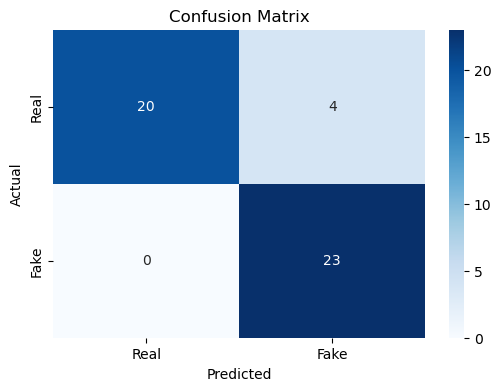

In [173]:
# ----------- Cell 11: Confusion Matrix -----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Real', 'Fake'], 
            yticklabels=['Real', 'Fake'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig(r"D:\Chinmay\ML PROJECTS\Fake News Detection")
plt.show()

In [174]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

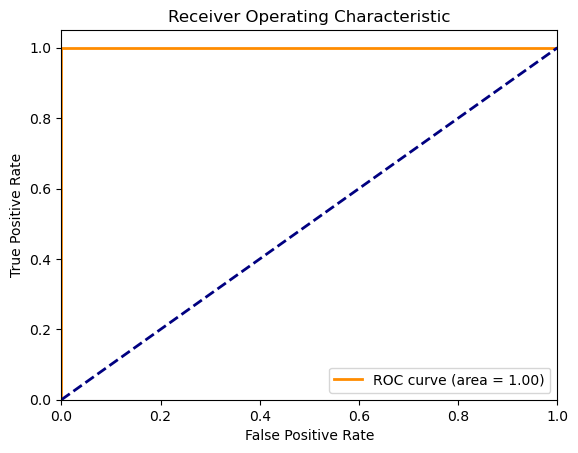

In [175]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(r"D:\Chinmay\ML PROJECTS\Fake News Detection")
plt.show()

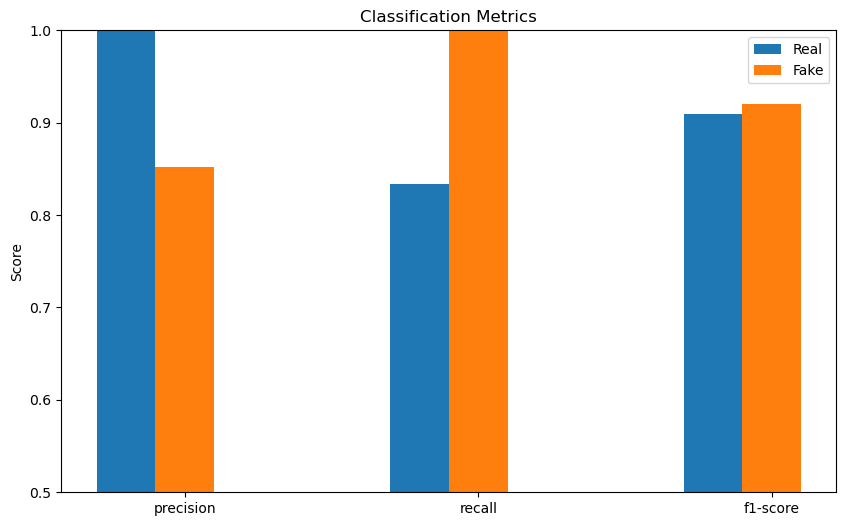

In [176]:
# ----------- Cell 13: Metrics Visualization -----------
report = classification_report(y_test, y_pred, output_dict=True)
metrics = ['precision', 'recall', 'f1-score']
classes = ['Real', 'Fake']

plt.figure(figsize=(10,6))
for i, cls in enumerate(classes):
    plt.bar(np.arange(len(metrics)) + i*0.2, 
            [report[str(i)][metric] for metric in metrics],
            width=0.2, label=cls)

plt.xticks(np.arange(len(metrics)) + 0.2, metrics)
plt.ylabel('Score')
plt.ylim(0.5, 1.0)
plt.title('Classification Metrics')
plt.legend()
plt.savefig(r"D:\Chinmay\ML PROJECTS\Fake News Detection")
plt.show()


In [177]:
import joblib

# Load the trained model
model = joblib.load('fake_news_model.pkl')

# Ensure text cleaning function is available
def predict_news(text):
    cleaned = clean_text(text)
    prediction = model.predict([cleaned])[0]
    
    if prediction == 1:
        return "Fake"
    else:
        return "Real"


In [178]:
text = ""
predict_news(text)

'Fake'